Reproduce the results of the FFNN with 1 hidden layer of 5 units on the unbalanced dataset.

In [1]:
import numpy as np
import tensorflow as tf
import pickle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix 
import matplotlib.pyplot as plt

#import test set
with open('test_sentences_id_unbalanced.pickle','rb') as file:
    test_sentences = pickle.load(file)
    
with open('test_labels_unbalanced.pickle','rb') as file:
    test_bin_labels = pickle.load(file)


/Users/claire/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
#input and label processing
num_test=len(test_sentences)
num_words=10391
test_exemples = np.zeros((num_test, num_words))
for (i,sent) in enumerate(test_sentences):
        for (j,word) in enumerate(sent):
            test_exemples[i,word-1] = 1
            
test_labels=np.zeros((len(test_bin_labels),2))

for (i,lab) in enumerate(test_bin_labels):
    if(lab==1):
        test_labels[i,1]=1
    else:
        test_labels[i,0]=1

INFO:tensorflow:Restoring parameters from ffnn_5units_unbalanced
Test Accuracy  0.927, Test AUC  0.646, Test Sensitivity  0.000, Test Specificity  1.000


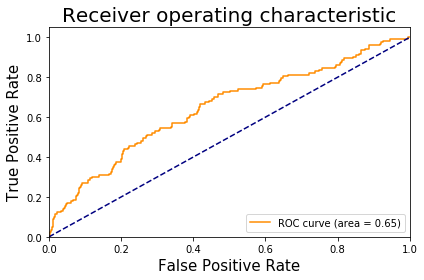

In [3]:
sess=tf.Session()    

#load meta graph and restore weights
saver = tf.train.import_meta_graph('ffnn_5units_unbalanced.meta')
saver.restore(sess, 'ffnn_5units_unbalanced')

graph = tf.get_default_graph()

x_pl = graph.get_tensor_by_name("xPlaceholder:0")
y_pl = graph.get_tensor_by_name("yPlaceholder:0")
threshold_pl = graph.get_tensor_by_name("thresholdPlaceholder:0")
dropout_pl=graph.get_tensor_by_name("dropoutPlaceholder:0")
accuracy=graph.get_tensor_by_name("performance/accuracy:0")
specificity=graph.get_tensor_by_name("performance/specificity:0")
predictions=graph.get_tensor_by_name("performance/predictions:0")
l_out=graph.get_tensor_by_name("l_out/Softmax:0")


threshold=0.35


feed_dict_test = {x_pl: test_exemples, y_pl: test_labels, threshold_pl : threshold, dropout_pl: 1}
fetches_test = [accuracy, specificity, predictions, l_out]
test_acc, test_spec, test_pred, test_prob = sess.run(fetches_test, feed_dict_test)

fpr_test, tpr_test, _ = roc_curve(test_bin_labels, test_prob[:,1])
test_auc = auc(fpr_test, tpr_test)
TN, FP, FN, TP = confusion_matrix(test_bin_labels, test_pred).ravel()
test_sens = TP / float(FN + TP) 
    
print('Test Accuracy {:6.3f}, Test AUC {:6.3f}, Test Sensitivity {:6.3f}, Test Specificity {:6.3f}'.format(
                test_acc, test_auc, test_sens, test_spec))

plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve (area = %0.2f)' % test_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
